In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
CSV_PATH = './csv/small'
RATING_FILE = os.path.join(CSV_PATH, 'ratings.csv')
MOVIE_FILE = os.path.join(CSV_PATH, 'movies.csv')
GENRE_FILE = os.path.join(CSV_PATH, 'genres.csv')
PRINCIPALS_FILE = os.path.join(CSV_PATH, 'principals.csv')
PERSON_FILE = os.path.join(CSV_PATH, 'persons.csv')

In [3]:
def load_csv(filepath, sep=','):
    """Charge un fichier CSV et retourne un DataFrame."""
    try:
        df = pd.read_csv(filepath, sep=sep, na_values=['\\N', ' '])
        print(f"Chargement de {os.path.basename(filepath)} réussi.")
        return df
    except FileNotFoundError:
        print(f"ERREUR: Fichier non trouvé à {filepath}. Assurez-vous que les données sont dézippées au bon endroit.")
        return None
    except Exception as e:
        print(f"ERREUR lors du chargement de {filepath}: {e}")
        return None

In [4]:
# Chargement des DataFrames principaux
df_movies = load_csv(MOVIE_FILE)
df_ratings = load_csv(RATING_FILE)
df_genres = load_csv(GENRE_FILE)
df_principals = load_csv(PRINCIPALS_FILE)
df_persons = load_csv(PERSON_FILE, sep=',')

Chargement de movies.csv réussi.
Chargement de ratings.csv réussi.
Chargement de genres.csv réussi.
Chargement de principals.csv réussi.
Chargement de persons.csv réussi.
Chargement de principals.csv réussi.
Chargement de persons.csv réussi.


In [5]:
dfs = {
    'movies': df_movies,
    'ratings': df_ratings,
    'genres': df_genres,
    'principals': df_principals,
    'persons': df_persons
}
# Filtrer les DataFrames qui n'ont pas pu être chargés
dfs = {k: v for k, v in dfs.items() if v is not None}

In [ ]:
print("\n## 2. Statistiques descriptives")
for name, df in dfs.items():
    print(f"\n### {name.upper()}")
    # 1. Nombre de lignes et colonnes
    print(f"Dimensions (Lignes, Colonnes) : {df.shape}")

    # 2. Types de données et valeurs non nulles
    print("\nTypes de données et valeurs non nulles :")
    df.info()

    # 3. Statistiques pour colonnes numériques/quantitatives
    print("\nStatistiques pour colonnes quantitatives :")
    print(df.describe())

    # 4. Valeurs manquantes (NaN, chaînes vides)
    print("\nCompte des valeurs manquantes (NaN) par colonne :")
    print(df.isnull().sum().sort_values(ascending=False))

    # 5. Valeurs uniques par colonne
    print("\nNombre de valeurs uniques par colonne (Top 5) :")
    print(df.nunique().sort_values(ascending=False).head())


## 3. Analyses exploratoires

### Distribution des films par année


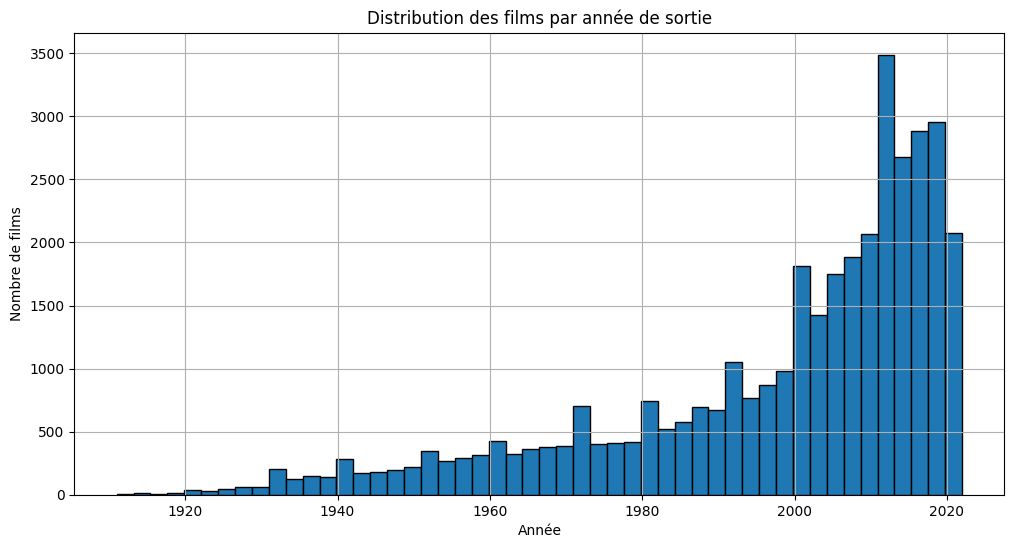


### Top 10 des genres les plus fréquents


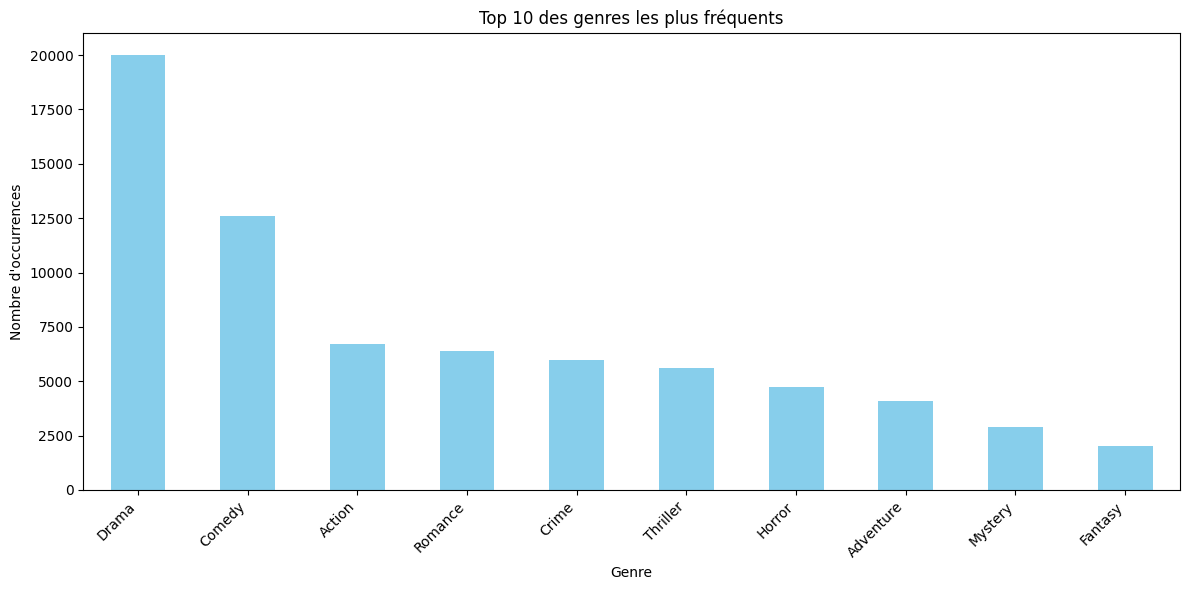


### Distribution des notes moyennes


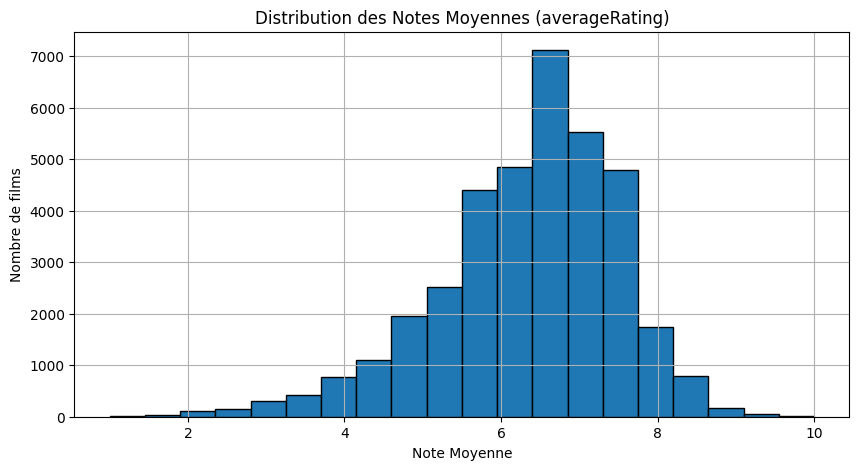


Nombre moyen de 'principaux' (acteurs/réalisateurs...) par film : 9.82


In [6]:
print("\n## 3. Analyses exploratoires")

# Jointure des tables pour les analyses (si chargées)
if 'movies' in dfs and 'ratings' in dfs:
    df_merged = pd.merge(df_movies, df_ratings, on="mid", how='left')

    # 1. Distribution des films par année (histogramme)
    print("\n### Distribution des films par année")
    plt.figure(figsize=(12, 6))
    # Utiliser 'start_year' de movies.csv pour la distribution si elle existe
    if "startYear" in df_merged.columns:
        df_merged["startYear"].hist(bins=50, edgecolor='black')
        plt.title('Distribution des films par année de sortie')
        plt.xlabel('Année')
        plt.ylabel('Nombre de films')
        plt.show() #
    # 2. Top 10 des genres les plus fréquents
    print("\n### Top 10 des genres les plus fréquents")
    # 'genres.csv' est la table de mapping pour les genres
    if "genres" in dfs:
        genre_counts = dfs['genres']["genre"].value_counts().head(10)

        plt.figure(figsize=(12, 6))
        genre_counts.plot(kind='bar', color='skyblue')
        plt.title('Top 10 des genres les plus fréquents')
        plt.xlabel('Genre')
        plt.ylabel('Nombre d\'occurrences')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show() #
    # 3. Distribution des notes (ratings)
    print("\n### Distribution des notes moyennes")
    plt.figure(figsize=(10, 5))
    if "averageRating" in df_merged.columns:
        df_merged["averageRating"].hist(bins=20, edgecolor='black')
        plt.title('Distribution des Notes Moyennes (averageRating)')
        plt.xlabel('Note Moyenne')
        plt.ylabel('Nombre de films')
        plt.show() #
    # 4. Nombre moyen d'acteurs par film
    if "principals" in dfs and 'persons' in dfs:
        # Filtrer uniquement les acteurs (category='actor' ou 'actress' dans principals si disponible)
        # Ici, on compte tous les "principaux" par film, ce qui est une bonne approximation.
        principals_per_movie = df_principals.groupby("mid").size()
        mean_principals = principals_per_movie.mean()
        print(
            f"\nNombre moyen de 'principaux' (acteurs/réalisateurs...) par film : {mean_principals:.2f}"
        )

In [7]:
print("\n## 4. Relations entre tables")

# Vérifier l'intégrité référentielle (Clés Étrangères)
if 'movies' in dfs and 'ratings' in dfs:
    # 1. Vérifier les clés étrangères (tous les movie_id existent-ils?)
    # Films dans Ratings qui ne sont pas dans Movies
    ratings_movie_ids = set(df_ratings["mid"])
    movies_movie_ids = set(df_movies["mid"])

    # Données orphelines dans ratings (movie_id sans correspondance dans movies)
    orphan_ratings = ratings_movie_ids - movies_movie_ids

    print(f"\nNombre de 'movie_id' dans 'ratings' qui n'ont pas de correspondance dans 'movies' (Orphelins dans ratings) : {len(orphan_ratings)}")

    # 2. Données orphelines dans movies (movie_id sans note dans ratings)
    orphan_movies = movies_movie_ids - ratings_movie_ids

    print(f"Nombre de 'movie_id' dans 'movies' qui n'ont pas de note dans 'ratings' (Films sans note) : {len(orphan_movies)}")

    if len(orphan_ratings) > 0:
        print("Il y a des données orphelines dans 'ratings' qui devront être gérées (ignorées ou nettoyées) lors de l'importation SQL.")
    else:
        print("Aucun 'movie_id' orphelin détecté dans 'ratings' par rapport à 'movies'.")


## 4. Relations entre tables

Nombre de 'movie_id' dans 'ratings' qui n'ont pas de correspondance dans 'movies' (Orphelins dans ratings) : 0
Nombre de 'movie_id' dans 'movies' qui n'ont pas de note dans 'ratings' (Films sans note) : 0
Aucun 'movie_id' orphelin détecté dans 'ratings' par rapport à 'movies'.
